In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from tqdm import tqdm
import copy

In [7]:
# === Section 2: Load CoralSeg Dataset ===

BASE_PATH = "../benthic_data"
CORALSEG_PATH = os.path.join(BASE_PATH, "Coralseg")

splits = ["train", "val", "test"]
coralseg_data = []

for split in splits:
    img_dir = os.path.join(CORALSEG_PATH, split, "Image")
    mask_dir = os.path.join(CORALSEG_PATH, split, "Mask")

    img_files = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

    # Match by filename
    for img_path in img_files:
        fname = os.path.basename(img_path).replace(".jpg", "")
        mask_path = os.path.join(mask_dir, fname + ".png")
        if os.path.exists(mask_path):
            coralseg_data.append({
                "dataset": "CoralSeg",
                "split": split,
                "image_path": img_path,
                "mask_path": mask_path
            })

coralseg_df = pd.DataFrame(coralseg_data)
print(f"✅ CoralSeg loaded: {len(coralseg_df)} total samples")
print(coralseg_df.sample(3))



✅ CoralSeg loaded: 4922 total samples
       dataset  split                                         image_path  \
645   CoralSeg  train  ../benthic_data\Coralseg\train\Image\FR7_6144_...   
3569  CoralSeg  train  ../benthic_data\Coralseg\train\Image\PALWave39...   
2140  CoralSeg  train  ../benthic_data\Coralseg\train\Image\PALStrawn...   

                                              mask_path  
645   ../benthic_data\Coralseg\train\Mask\FR7_6144_6...  
3569  ../benthic_data\Coralseg\train\Mask\PALWave39_...  
2140  ../benthic_data\Coralseg\train\Mask\PALStrawn_...  


In [8]:
# === Section 3: Load reef_support datasets ===

REEF_SUPPORT_PATH = os.path.join(BASE_PATH, "reef_support")

reef_data = []

# Loop through each reef site
for site in sorted(os.listdir(REEF_SUPPORT_PATH)):
    site_dir = os.path.join(REEF_SUPPORT_PATH, site)
    img_dir = os.path.join(site_dir, "images")
    stitched_dir = os.path.join(site_dir, "masks_stitched")
    masks_dir = os.path.join(site_dir, "masks")

    if not os.path.isdir(img_dir):
        continue

    print(f"📂 Processing site: {site}")

    # Prefer stitched masks (cleaner)
    stitched_masks = sorted(glob.glob(os.path.join(stitched_dir, "*.png")))
    for mask_path in stitched_masks:
        fname = os.path.basename(mask_path).replace("_mask.png", "").replace(".png", "")
        img_candidates = glob.glob(os.path.join(img_dir, f"{fname}.*"))
        if len(img_candidates) == 0:
            continue
        img_path = img_candidates[0]

        reef_data.append({
            "dataset": site,
            "split": "train",  # no official split, will randomize later
            "image_path": img_path,
            "mask_path": mask_path
        })

reef_df = pd.DataFrame(reef_data)
print(f"✅ reef_support loaded: {len(reef_df)} samples across {reef_df['dataset'].nunique()} sites")
reef_df.sample(5)


📂 Processing site: SEAFLOWER_BOLIVAR
📂 Processing site: SEAFLOWER_COURTOWN
📂 Processing site: SEAVIEW_ATL
📂 Processing site: SEAVIEW_IDN_PHL
📂 Processing site: SEAVIEW_PAC_AUS
📂 Processing site: SEAVIEW_PAC_USA
📂 Processing site: TETES_PROVIDENCIA
📂 Processing site: UNAL_BLEACHING_TAYRONA
✅ reef_support loaded: 3311 samples across 8 sites


,dataset,split,image_path,mask_path
1501,SEAVIEW_IDN_PHL,train,../benthic_data\reef_support\SEAVIEW_IDN_PHL\i...,../benthic_data\reef_support\SEAVIEW_IDN_PHL\m...
703,SEAVIEW_ATL,train,../benthic_data\reef_support\SEAVIEW_ATL\image...,../benthic_data\reef_support\SEAVIEW_ATL\masks...
1809,SEAVIEW_PAC_AUS,train,../benthic_data\reef_support\SEAVIEW_PAC_AUS\i...,../benthic_data\reef_support\SEAVIEW_PAC_AUS\m...
1258,SEAVIEW_IDN_PHL,train,../benthic_data\reef_support\SEAVIEW_IDN_PHL\i...,../benthic_data\reef_support\SEAVIEW_IDN_PHL\m...
127,SEAFLOWER_BOLIVAR,train,../benthic_data\reef_support\SEAFLOWER_BOLIVAR...,../benthic_data\reef_support\SEAFLOWER_BOLIVAR...


In [10]:
import cv2
from tqdm import tqdm

SAVE_UNION_DIR = "../coral_project_outputs/union_masks"
os.makedirs(SAVE_UNION_DIR, exist_ok=True)

merged_data = []

def make_union_mask(mask_dir, target_name):
    """Combine all *_mask_*.png files into one binary union mask."""
    masks = glob.glob(os.path.join(mask_dir, f"{target_name}_mask_*.png"))
    if not masks:
        return None

    combined = None
    for mpath in masks:
        mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        mask = (mask > 0).astype(np.uint8)
        combined = mask if combined is None else np.maximum(combined, mask)

    if combined is None:
        return None

    save_path = os.path.join(SAVE_UNION_DIR, f"{target_name}_union.png")
    cv2.imwrite(save_path, combined * 255)
    return save_path

# Process reef_support sites (including union masks)
for _, row in tqdm(reef_df.iterrows(), total=len(reef_df)):
    img_path = row["image_path"]
    site_dir = os.path.dirname(os.path.dirname(img_path))
    masks_dir = os.path.join(site_dir, "masks")
    fname = os.path.splitext(os.path.basename(img_path))[0]

    # Try to create or find best mask
    if os.path.exists(os.path.join(site_dir, "masks_stitched", f"{fname}_mask.png")):
        mask_path = os.path.join(site_dir, "masks_stitched", f"{fname}_mask.png")
    else:
        mask_path = make_union_mask(masks_dir, fname)

    if mask_path and os.path.exists(mask_path):
        merged_data.append({
            "dataset": row["dataset"],
            "split": "train",
            "image_path": img_path,
            "mask_path": mask_path
        })
# Add CoralSeg dataset
for _, row in tqdm(coralseg_df.iterrows(), total=len(coralseg_df)):
    merged_data.append({
        "dataset": row["dataset"],
        "split": row["split"],
        "image_path": row["image_path"],
        "mask_path": row["mask_path"]
    })
merged_df = pd.DataFrame(merged_data)

# Clean — remove empties
def valid_mask(path):
    if not os.path.exists(path):
        return False
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return mask is not None and mask.sum() > 0

test_df = merged_df[merged_df["mask_path"].apply(valid_mask)].reset_index(drop=True)

print(f"✅ Final merged dataset size: {len(test_df)} samples")
print(test_df.groupby("dataset").size())

# Save CSV metadata for reuse
csv_path = "../coral_project_outputs/merged_dataset.csv"
test_df.to_csv(csv_path, index=False)
print(f"💾 Saved metadata to {csv_path}")


NameError: name 'reef_df' is not defined

In [3]:
csv_path = "../coral_project_outputs/merged_dataset.csv"

merged_df = pd.read_csv(csv_path)
print(f"✅ Reloaded merged dataset: {len(merged_df)} samples")
print(merged_df.groupby("dataset").size())

# Optional sanity check
sample = merged_df.sample(3, random_state=42)
for _, row in sample.iterrows():
    assert os.path.exists(row["image_path"]), f"Missing image {row['image_path']}"
    assert os.path.exists(row["mask_path"]), f"Missing mask {row['mask_path']}"
print("✅ Random sample files verified")


✅ Reloaded merged dataset: 3276 samples
dataset
SEAFLOWER_BOLIVAR         245
SEAFLOWER_COURTOWN        241
SEAVIEW_ATL               651
SEAVIEW_IDN_PHL           466
SEAVIEW_PAC_AUS           657
SEAVIEW_PAC_USA           276
TETES_PROVIDENCIA         105
UNAL_BLEACHING_TAYRONA    635
dtype: int64
✅ Random sample files verified


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import torch
from coral_dataset import CoralDataset

# -------------------
# Split data
train_df, val_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=None)
print(f"📊 Train: {len(train_df)} | Val: {len(val_df)}")

# -------------------
# Augmentations
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2(),
])

# -------------------
# Datasets & Dataloaders

train_dataset = CoralDataset(train_df, transform=train_transform)
val_dataset   = CoralDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=6, persistent_workers=True, pin_memory=True, prefetch_factor=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False,
                          num_workers=6, persistent_workers=True, pin_memory=True, prefetch_factor=2)


# -------------------
# Quick check
imgs, masks = next(iter(train_loader))
print(f"✅ Dataloader OK — batch shapes: imgs {imgs.shape}, masks {masks.shape}")


📊 Train: 2620 | Val: 656
✅ Dataloader OK — batch shapes: imgs torch.Size([4, 3, 256, 256]), masks torch.Size([4, 1, 256, 256])


Using device: cuda


Epoch 1/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.93it/s]



Epoch 1/200
 Train Loss: 0.5297 | IoU: 0.4200 | Acc: 0.7274
 Val   Loss: 0.4094 | IoU: 0.5125 | Acc: 0.8300
  ✅ Saved new best model with IoU=0.5125


Epoch 2/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.92it/s]



Epoch 2/200
 Train Loss: 0.4222 | IoU: 0.5001 | Acc: 0.8162
 Val   Loss: 0.3769 | IoU: 0.5303 | Acc: 0.8532
  ✅ Saved new best model with IoU=0.5303


Epoch 3/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.95it/s]



Epoch 3/200
 Train Loss: 0.3947 | IoU: 0.5246 | Acc: 0.8292
 Val   Loss: 0.3621 | IoU: 0.5504 | Acc: 0.8515
  ✅ Saved new best model with IoU=0.5504


Epoch 4/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.96it/s]



Epoch 4/200
 Train Loss: 0.3687 | IoU: 0.5542 | Acc: 0.8434
 Val   Loss: 0.3423 | IoU: 0.5727 | Acc: 0.8607
  ✅ Saved new best model with IoU=0.5727


Epoch 5/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.98it/s]



Epoch 5/200
 Train Loss: 0.3532 | IoU: 0.5727 | Acc: 0.8516
 Val   Loss: 0.3441 | IoU: 0.5668 | Acc: 0.8623


Epoch 6/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.06it/s]



Epoch 6/200
 Train Loss: 0.3400 | IoU: 0.5857 | Acc: 0.8599
 Val   Loss: 0.3309 | IoU: 0.5814 | Acc: 0.8706
  ✅ Saved new best model with IoU=0.5814


Epoch 7/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.01it/s]



Epoch 7/200
 Train Loss: 0.3300 | IoU: 0.5937 | Acc: 0.8648
 Val   Loss: 0.3353 | IoU: 0.5796 | Acc: 0.8668


Epoch 8/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.01it/s]



Epoch 8/200
 Train Loss: 0.3148 | IoU: 0.6109 | Acc: 0.8714
 Val   Loss: 0.3348 | IoU: 0.5908 | Acc: 0.8656
  ✅ Saved new best model with IoU=0.5908


Epoch 9/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.05it/s]



Epoch 9/200
 Train Loss: 0.3095 | IoU: 0.6179 | Acc: 0.8748
 Val   Loss: 0.3278 | IoU: 0.5952 | Acc: 0.8640
  ✅ Saved new best model with IoU=0.5952


Epoch 10/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.01it/s]



Epoch 10/200
 Train Loss: 0.3015 | IoU: 0.6265 | Acc: 0.8790
 Val   Loss: 0.3331 | IoU: 0.6002 | Acc: 0.8684
  ✅ Saved new best model with IoU=0.6002


Epoch 11/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.08it/s]



Epoch 11/200
 Train Loss: 0.2960 | IoU: 0.6311 | Acc: 0.8805
 Val   Loss: 0.3393 | IoU: 0.5948 | Acc: 0.8632


Epoch 12/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.04it/s]



Epoch 12/200
 Train Loss: 0.2925 | IoU: 0.6326 | Acc: 0.8829
 Val   Loss: 0.3360 | IoU: 0.5968 | Acc: 0.8662


Epoch 13/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.10it/s]



Epoch 13/200
 Train Loss: 0.2801 | IoU: 0.6479 | Acc: 0.8876
 Val   Loss: 0.3324 | IoU: 0.5996 | Acc: 0.8603


Epoch 14/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.99it/s]



Epoch 14/200
 Train Loss: 0.2806 | IoU: 0.6476 | Acc: 0.8872
 Val   Loss: 0.3100 | IoU: 0.6135 | Acc: 0.8766
  ✅ Saved new best model with IoU=0.6135


Epoch 15/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.07it/s]



Epoch 15/200
 Train Loss: 0.2758 | IoU: 0.6513 | Acc: 0.8892
 Val   Loss: 0.3065 | IoU: 0.6162 | Acc: 0.8757
  ✅ Saved new best model with IoU=0.6162


Epoch 16/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.01it/s]



Epoch 16/200
 Train Loss: 0.2663 | IoU: 0.6614 | Acc: 0.8940
 Val   Loss: 0.3030 | IoU: 0.6170 | Acc: 0.8812
  ✅ Saved new best model with IoU=0.6170


Epoch 17/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.11it/s]



Epoch 17/200
 Train Loss: 0.2631 | IoU: 0.6647 | Acc: 0.8952
 Val   Loss: 0.3254 | IoU: 0.6122 | Acc: 0.8699


Epoch 18/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.07it/s]



Epoch 18/200
 Train Loss: 0.2606 | IoU: 0.6675 | Acc: 0.8965
 Val   Loss: 0.3169 | IoU: 0.6091 | Acc: 0.8722


Epoch 19/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.14it/s]



Epoch 19/200
 Train Loss: 0.2577 | IoU: 0.6703 | Acc: 0.8976
 Val   Loss: 0.3113 | IoU: 0.6136 | Acc: 0.8768


Epoch 20/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.12it/s]



Epoch 20/200
 Train Loss: 0.2520 | IoU: 0.6791 | Acc: 0.9001
 Val   Loss: 0.3055 | IoU: 0.6188 | Acc: 0.8779
  ✅ Saved new best model with IoU=0.6188


Epoch 21/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.12it/s]



Epoch 21/200
 Train Loss: 0.2511 | IoU: 0.6790 | Acc: 0.8998
 Val   Loss: 0.3085 | IoU: 0.6102 | Acc: 0.8808


Epoch 22/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.06it/s]



Epoch 22/200
 Train Loss: 0.2438 | IoU: 0.6845 | Acc: 0.9036
 Val   Loss: 0.3020 | IoU: 0.6226 | Acc: 0.8836
  ✅ Saved new best model with IoU=0.6226


Epoch 23/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.06it/s]



Epoch 23/200
 Train Loss: 0.2448 | IoU: 0.6862 | Acc: 0.9027
 Val   Loss: 0.2953 | IoU: 0.6306 | Acc: 0.8850
  ✅ Saved new best model with IoU=0.6306


Epoch 24/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.09it/s]



Epoch 24/200
 Train Loss: 0.2425 | IoU: 0.6887 | Acc: 0.9039
 Val   Loss: 0.3033 | IoU: 0.6230 | Acc: 0.8825


Epoch 25/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.07it/s]



Epoch 25/200
 Train Loss: 0.2365 | IoU: 0.6945 | Acc: 0.9058
 Val   Loss: 0.2965 | IoU: 0.6225 | Acc: 0.8853


Epoch 26/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.15it/s]



Epoch 26/200
 Train Loss: 0.2352 | IoU: 0.6971 | Acc: 0.9074
 Val   Loss: 0.3089 | IoU: 0.6222 | Acc: 0.8806


Epoch 27/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.18it/s]



Epoch 27/200
 Train Loss: 0.2313 | IoU: 0.7002 | Acc: 0.9082
 Val   Loss: 0.2968 | IoU: 0.6286 | Acc: 0.8840


Epoch 28/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.10it/s]



Epoch 28/200
 Train Loss: 0.2323 | IoU: 0.6983 | Acc: 0.9085
 Val   Loss: 0.3216 | IoU: 0.6075 | Acc: 0.8729


Epoch 29/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.08it/s]



Epoch 29/200
 Train Loss: 0.2296 | IoU: 0.7030 | Acc: 0.9095
 Val   Loss: 0.3089 | IoU: 0.6230 | Acc: 0.8811


Epoch 30/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.10it/s]



Epoch 30/200
 Train Loss: 0.2262 | IoU: 0.7074 | Acc: 0.9104
 Val   Loss: 0.3039 | IoU: 0.6269 | Acc: 0.8789


Epoch 31/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.90it/s]



Epoch 31/200
 Train Loss: 0.2234 | IoU: 0.7085 | Acc: 0.9117
 Val   Loss: 0.2877 | IoU: 0.6363 | Acc: 0.8875
  ✅ Saved new best model with IoU=0.6363


Epoch 32/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.78it/s]



Epoch 32/200
 Train Loss: 0.2206 | IoU: 0.7136 | Acc: 0.9127
 Val   Loss: 0.2995 | IoU: 0.6235 | Acc: 0.8891


Epoch 33/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.90it/s]



Epoch 33/200
 Train Loss: 0.2209 | IoU: 0.7118 | Acc: 0.9132
 Val   Loss: 0.2968 | IoU: 0.6250 | Acc: 0.8902


Epoch 34/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.89it/s]



Epoch 34/200
 Train Loss: 0.2163 | IoU: 0.7173 | Acc: 0.9149
 Val   Loss: 0.2851 | IoU: 0.6399 | Acc: 0.8878
  ✅ Saved new best model with IoU=0.6399


Epoch 35/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.93it/s]



Epoch 35/200
 Train Loss: 0.2175 | IoU: 0.7158 | Acc: 0.9143
 Val   Loss: 0.2966 | IoU: 0.6369 | Acc: 0.8836


Epoch 36/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.98it/s]



Epoch 36/200
 Train Loss: 0.2128 | IoU: 0.7228 | Acc: 0.9159
 Val   Loss: 0.2842 | IoU: 0.6381 | Acc: 0.8918


Epoch 37/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.06it/s]



Epoch 37/200
 Train Loss: 0.2096 | IoU: 0.7253 | Acc: 0.9176
 Val   Loss: 0.2918 | IoU: 0.6357 | Acc: 0.8836


Epoch 38/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.13it/s]



Epoch 38/200
 Train Loss: 0.2156 | IoU: 0.7193 | Acc: 0.9152
 Val   Loss: 0.2949 | IoU: 0.6375 | Acc: 0.8806


Epoch 39/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.13it/s]



Epoch 39/200
 Train Loss: 0.2079 | IoU: 0.7280 | Acc: 0.9178
 Val   Loss: 0.2970 | IoU: 0.6362 | Acc: 0.8811


Epoch 40/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.17it/s]



Epoch 40/200
 Train Loss: 0.2040 | IoU: 0.7320 | Acc: 0.9194
 Val   Loss: 0.2895 | IoU: 0.6366 | Acc: 0.8896


Epoch 41/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.09it/s]



Epoch 41/200
 Train Loss: 0.2064 | IoU: 0.7296 | Acc: 0.9192
 Val   Loss: 0.2933 | IoU: 0.6337 | Acc: 0.8835


Epoch 42/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.19it/s]



Epoch 42/200
 Train Loss: 0.2049 | IoU: 0.7305 | Acc: 0.9200
 Val   Loss: 0.2957 | IoU: 0.6397 | Acc: 0.8841


Epoch 43/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.15it/s]



Epoch 43/200
 Train Loss: 0.1994 | IoU: 0.7376 | Acc: 0.9215
 Val   Loss: 0.2963 | IoU: 0.6380 | Acc: 0.8871


Epoch 44/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.13it/s]



Epoch 44/200
 Train Loss: 0.1997 | IoU: 0.7358 | Acc: 0.9218
 Val   Loss: 0.2806 | IoU: 0.6399 | Acc: 0.8903


Epoch 45/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.18it/s]



Epoch 45/200
 Train Loss: 0.1979 | IoU: 0.7399 | Acc: 0.9220
 Val   Loss: 0.2987 | IoU: 0.6332 | Acc: 0.8828


Epoch 46/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.16it/s]



Epoch 46/200
 Train Loss: 0.1986 | IoU: 0.7370 | Acc: 0.9223
 Val   Loss: 0.2952 | IoU: 0.6306 | Acc: 0.8887


Epoch 47/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.12it/s]



Epoch 47/200
 Train Loss: 0.1956 | IoU: 0.7406 | Acc: 0.9233
 Val   Loss: 0.2892 | IoU: 0.6361 | Acc: 0.8860


Epoch 48/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.11it/s]



Epoch 48/200
 Train Loss: 0.1927 | IoU: 0.7466 | Acc: 0.9240
 Val   Loss: 0.2956 | IoU: 0.6381 | Acc: 0.8914


Epoch 49/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.09it/s]



Epoch 49/200
 Train Loss: 0.1916 | IoU: 0.7471 | Acc: 0.9251
 Val   Loss: 0.2965 | IoU: 0.6409 | Acc: 0.8830
  ✅ Saved new best model with IoU=0.6409


Epoch 50/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.12it/s]



Epoch 50/200
 Train Loss: 0.1905 | IoU: 0.7480 | Acc: 0.9252
 Val   Loss: 0.2878 | IoU: 0.6438 | Acc: 0.8896
  ✅ Saved new best model with IoU=0.6438


Epoch 51/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.13it/s]



Epoch 51/200
 Train Loss: 0.1891 | IoU: 0.7504 | Acc: 0.9257
 Val   Loss: 0.2860 | IoU: 0.6393 | Acc: 0.8878


Epoch 52/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.14it/s]



Epoch 52/200
 Train Loss: 0.1904 | IoU: 0.7465 | Acc: 0.9259
 Val   Loss: 0.2912 | IoU: 0.6395 | Acc: 0.8887


Epoch 53/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.15it/s]



Epoch 53/200
 Train Loss: 0.1871 | IoU: 0.7521 | Acc: 0.9267
 Val   Loss: 0.3006 | IoU: 0.6335 | Acc: 0.8865


Epoch 54/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.16it/s]



Epoch 54/200
 Train Loss: 0.1885 | IoU: 0.7499 | Acc: 0.9265
 Val   Loss: 0.3087 | IoU: 0.6376 | Acc: 0.8822


Epoch 55/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.16it/s]



Epoch 55/200
 Train Loss: 0.1824 | IoU: 0.7573 | Acc: 0.9287
 Val   Loss: 0.2986 | IoU: 0.6359 | Acc: 0.8908


Epoch 56/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.13it/s]



Epoch 56/200
 Train Loss: 0.1834 | IoU: 0.7567 | Acc: 0.9285
 Val   Loss: 0.2926 | IoU: 0.6332 | Acc: 0.8872


Epoch 57/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.09it/s]



Epoch 57/200
 Train Loss: 0.1815 | IoU: 0.7594 | Acc: 0.9289
 Val   Loss: 0.3108 | IoU: 0.6357 | Acc: 0.8800


Epoch 58/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.16it/s]



Epoch 58/200
 Train Loss: 0.1806 | IoU: 0.7606 | Acc: 0.9291
 Val   Loss: 0.2952 | IoU: 0.6356 | Acc: 0.8846


Epoch 59/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.12it/s]



Epoch 59/200
 Train Loss: 0.1785 | IoU: 0.7626 | Acc: 0.9301
 Val   Loss: 0.2941 | IoU: 0.6345 | Acc: 0.8911


Epoch 60/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.19it/s]



Epoch 60/200
 Train Loss: 0.1798 | IoU: 0.7628 | Acc: 0.9295
 Val   Loss: 0.2893 | IoU: 0.6426 | Acc: 0.8911


Epoch 61/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.19it/s]



Epoch 61/200
 Train Loss: 0.1776 | IoU: 0.7650 | Acc: 0.9305
 Val   Loss: 0.2983 | IoU: 0.6360 | Acc: 0.8878


Epoch 62/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.16it/s]



Epoch 62/200
 Train Loss: 0.1742 | IoU: 0.7679 | Acc: 0.9317
 Val   Loss: 0.3010 | IoU: 0.6380 | Acc: 0.8852


Epoch 63/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.15it/s]



Epoch 63/200
 Train Loss: 0.1737 | IoU: 0.7679 | Acc: 0.9323
 Val   Loss: 0.3020 | IoU: 0.6379 | Acc: 0.8932


Epoch 64/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.14it/s]



Epoch 64/200
 Train Loss: 0.1723 | IoU: 0.7702 | Acc: 0.9325
 Val   Loss: 0.3040 | IoU: 0.6324 | Acc: 0.8869


Epoch 65/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.12it/s]



Epoch 65/200
 Train Loss: 0.1754 | IoU: 0.7652 | Acc: 0.9313
 Val   Loss: 0.2959 | IoU: 0.6388 | Acc: 0.8883


Epoch 66/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.18it/s]



Epoch 66/200
 Train Loss: 0.1698 | IoU: 0.7731 | Acc: 0.9332
 Val   Loss: 0.2975 | IoU: 0.6326 | Acc: 0.8903


Epoch 67/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.18it/s]



Epoch 67/200
 Train Loss: 0.1690 | IoU: 0.7749 | Acc: 0.9339
 Val   Loss: 0.2949 | IoU: 0.6372 | Acc: 0.8906


Epoch 68/200 - Val: 100%|██████████| 164/164 [00:16<00:00,  9.84it/s]



Epoch 68/200
 Train Loss: 0.1695 | IoU: 0.7731 | Acc: 0.9335
 Val   Loss: 0.2931 | IoU: 0.6426 | Acc: 0.8895


Epoch 69/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.21it/s]



Epoch 69/200
 Train Loss: 0.1702 | IoU: 0.7724 | Acc: 0.9337
 Val   Loss: 0.2958 | IoU: 0.6387 | Acc: 0.8885


Epoch 70/200 - Val: 100%|██████████| 164/164 [00:16<00:00, 10.22it/s]


Epoch 70/200
 Train Loss: 0.1674 | IoU: 0.7757 | Acc: 0.9345
 Val   Loss: 0.3008 | IoU: 0.6359 | Acc: 0.8892
⏹️ Early stopping at epoch 70
Training complete. Best IoU: 0.6438


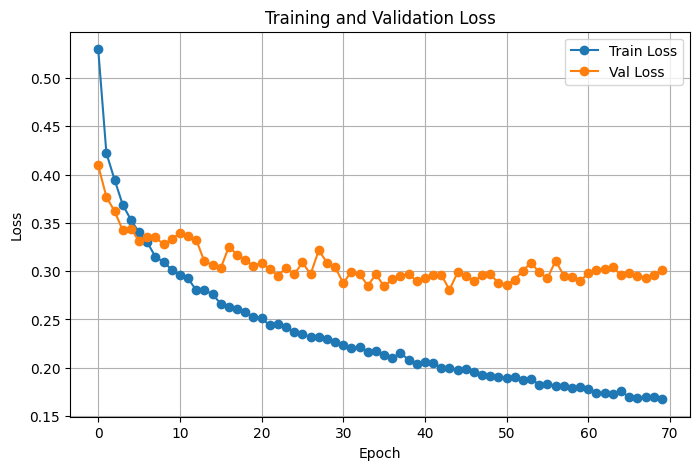

📈 Saved training curve to: ../coral_project_outputs/training_curve.png


<Figure size 640x480 with 0 Axes>

In [6]:
# === Section 6: Model setup and training (best config) ===
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# Model
model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)

# -------------------
# Loss: BCE + Dice combo
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode="binary")

def criterion(y_pred, y_true):
    return 0.5 * bce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# -------------------
# Metrics
def iou_score(y_pred, y_true, threshold=0.5):
    y_pred_bin = (torch.sigmoid(y_pred) > threshold).float()
    intersection = (y_pred_bin * y_true).sum()
    union = y_pred_bin.sum() + y_true.sum() - intersection
    return (intersection / union).item() if union > 0 else 1.0

def pixel_accuracy(y_pred, y_true, threshold=0.5):
    y_pred_bin = (torch.sigmoid(y_pred) > threshold).float()
    correct = (y_pred_bin == y_true).float().sum()
    total = torch.numel(y_true)
    return (correct / total).item()

# -------------------
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# -------------------
# Training loop
import matplotlib.pyplot as plt

# -------------------
# Training loop (with loss tracking + plotting)
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=5,
                save_path="../coral_project_outputs/best_merged_model.pth"):

    best_iou = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    # Track metrics per epoch
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_iou": [],
        "val_iou": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss, train_iou, train_acc = 0, 0, 0

        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += iou_score(outputs, masks)
            train_acc += pixel_accuracy(outputs, masks)

        # Validation
        model.eval()
        val_loss, val_iou, val_acc = 0, 0, 0
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += iou_score(outputs, masks)
                val_acc += pixel_accuracy(outputs, masks)

        # Averages
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_acc /= len(val_loader)

        # Store results
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_iou"].append(train_iou)
        history["val_iou"].append(val_iou)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f" Train Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | Acc: {train_acc:.4f}")
        print(f" Val   Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Acc: {val_acc:.4f}")

        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f"  ✅ Saved new best model with IoU={best_iou:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_wts)
    print(f"Training complete. Best IoU: {best_iou:.4f}")

    # === Plot training and validation loss ===
    os.makedirs(os.path.dirname("../coral_project_outputs/training_curve.png"), exist_ok=True)

    # Plot training curves
    plt.figure(figsize=(8, 5))
    plt.plot(history["train_loss"], label="Train Loss", marker="o")
    plt.plot(history["val_loss"], label="Val Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

        # Save the figure to file
    plt.savefig("../coral_project_outputs/training_curve.png", dpi=300)
    print(f"📈 Saved training curve to: {"../coral_project_outputs/training_curve.png"}")

    return model, history


# -------------------
# Run training
final_model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=200,
    patience=20
)


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
import random
from PIL import Image

import os

df = pd.read_csv("../coral_project_outputs/merged_dataset.csv")
print(f"✅ Reloaded dataset: {len(df)} samples")


✅ Reloaded dataset: 3276 samples


In [3]:
def compute_laplacian_variance(gray):
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def compute_lbp_variance(gray, P=8, R=1):
    lbp = feature.local_binary_pattern(gray, P, R, method="uniform")
    return np.var(lbp)

def compute_glcm_contrast(gray):
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return graycoprops(glcm, 'contrast')[0, 0]

def compute_entropy(gray):
    return shannon_entropy(gray)


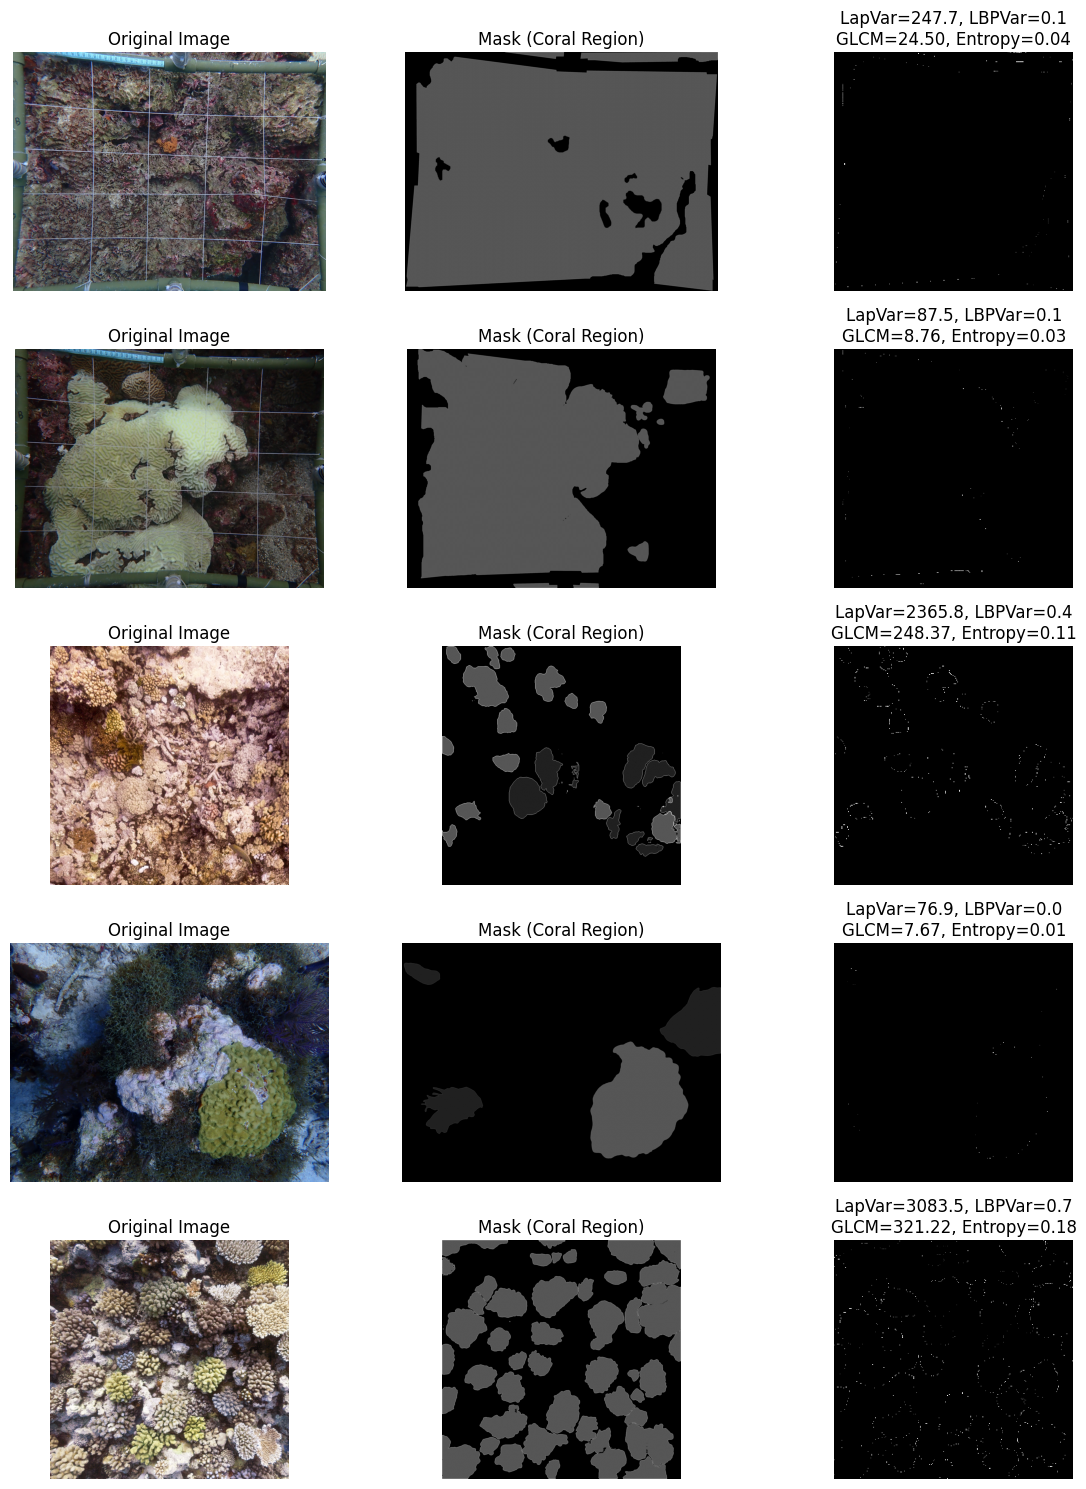

,image,lap_var,lbp_var,glcm_contrast,entropy
0,C4_Gy_PSb_T1_27nov24_CGomez_corr.jpg,247.720480,0.125099,24.504963,0.038685
1,C1_Gy_ESb_T1_27nov24_CGomez_corr.jpg,87.461486,0.119833,8.763358,0.034015
2,10001026002.jpg,2365.788880,0.414593,248.374341,0.111729
3,20220912_AnB_CB8 (26).JPG,76.927795,0.035884,7.666697,0.009725
4,15020226801.jpg,3083.530426,0.692524,321.221630,0.176557


In [4]:
n_samples = 5  # number of examples to visualize
samples = df.sample(n_samples, random_state=42)

fig, axes = plt.subplots(n_samples, 3, figsize=(12, 3 * n_samples))

feature_data = []

for i, row in enumerate(samples.itertuples()):
    img = np.array(Image.open(row.image_path).convert("RGB"))
    mask = np.array(Image.open(row.mask_path).convert("L"))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_resized = cv2.resize(gray, (256, 256))
    mask_resized = cv2.resize(mask, (256, 256))

    coral_region = cv2.bitwise_and(gray_resized, gray_resized, mask=(mask_resized > 127).astype(np.uint8))

    # Compute features
    lap_var = compute_laplacian_variance(coral_region)
    lbp_var = compute_lbp_variance(coral_region)
    glcm_contrast = compute_glcm_contrast(coral_region)
    entropy = compute_entropy(coral_region)

    feature_data.append({
        "image": os.path.basename(row.image_path),
        "lap_var": lap_var,
        "lbp_var": lbp_var,
        "glcm_contrast": glcm_contrast,
        "entropy": entropy
    })

    # Plot
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title("Mask (Coral Region)")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(coral_region, cmap="gray")
    axes[i, 2].set_title(
        f"LapVar={lap_var:.1f}, LBPVar={lbp_var:.1f}\nGLCM={glcm_contrast:.2f}, Entropy={entropy:.2f}"
    )
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

feature_df = pd.DataFrame(feature_data)
display(feature_df)


In [5]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parameters for texture computation ---
RADIUS = 2
N_POINTS = 8 * RADIUS

# Function to compute features INSIDE mask region only
def extract_masked_texture_features(img_path, mask_path):
    try:
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            return None

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = (mask > 127).astype(np.uint8)

        # Skip empty masks
        if np.sum(mask) < 100:
            return None

        # Find bounding box of the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None

        # Get the largest contour's bounding box
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Extract the masked region as a 2D patch
        gray_patch = gray[y:y+h, x:x+w]
        mask_patch = mask[y:y+h, x:x+w]

        # Apply mask to the patch
        gray_masked_patch = cv2.bitwise_and(gray_patch, gray_patch, mask=mask_patch)

        # Ensure the masked patch is valid for calculations
        if gray_masked_patch.sum() == 0:
            return None

        # --- Compute features ---
        # Apply Laplacian on the masked patch
        lap_var = cv2.Laplacian(gray_masked_patch, cv2.CV_64F).var()

        # Compute LBP on the masked patch
        lbp = local_binary_pattern(gray_masked_patch, N_POINTS, RADIUS, method="uniform")
        lbp_var = np.var(lbp)

        # Quantize and compute GLCM on the masked patch
        # Ensure patch is not empty after masking for GLCM
        if gray_masked_patch.size == 0:
             return None

        # Adjust quantization levels based on the actual pixel values in the masked patch
        max_val = np.max(gray_masked_patch) if gray_masked_patch.size > 0 else 0
        levels = min(max_val + 1, 256) # Ensure levels are within [0, 256] and at least 1 if max_val is 0
        if levels == 0: # Handle case where max_val is 0 for an empty patch
            quantized = np.zeros_like(gray_masked_patch, dtype=np.uint8)
        else:
            quantized = np.uint8(gray_masked_patch / (256 / levels))


        if quantized.size > 0 and levels > 1: # Check if quantized image is non-empty and has more than one level
            glcm = graycomatrix(quantized, [1], [0], levels=levels, symmetric=True, normed=True)
            glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
        else:
             glcm_contrast = 0 # Assign 0 if GLCM cannot be computed


        # Compute entropy on the pixel values within the masked patch
        region_values = gray_masked_patch[mask_patch > 0]
        if region_values.size > 0:
             entropy_val = shannon_entropy(region_values)
        else:
             entropy_val = 0 # Assign 0 if entropy cannot be computed on an empty region


        return {
            "lap_var": lap_var,
            "lbp_var": lbp_var,
            "glcm_contrast": glcm_contrast,
            "entropy": entropy_val
        }

    except Exception as e:
        print(f"Error on {img_path}: {e}")
        return None

subset_df = merged_df.sample(100, random_state=42)

masked_features = []
for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    feats = extract_masked_texture_features(row["image_path"], row["mask_path"])
    if feats:
        feats["image"] = row["image_path"].split("/")[-1]
        masked_features.append(feats)

masked_df = pd.DataFrame(masked_features)
print("✅ Masked texture features computed on coral regions only.")
print(masked_df.describe())

# --- Correlation heatmap ---
plt.figure(figsize=(5,4))
sns.heatmap(masked_df[['lap_var','lbp_var','glcm_contrast','entropy']].corr(),
            annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Between Masked Texture Features")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import cv2, numpy as np, skimage.feature as skf, skimage.measure as skm

def compute_texture_features(img_rgb, mask):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    gray_masked = gray * (mask > 0)

    # Laplacian variance (sharpness)
    lap_var = cv2.Laplacian(gray_masked, cv2.CV_64F).var()

    # Local Binary Pattern variance
    lbp = skf.local_binary_pattern(gray_masked, P=8, R=1, method='uniform')
    lbp_var = lbp.var()

    # GLCM contrast
    glcm = skf.graycomatrix(gray_masked, [1], [0], symmetric=True, normed=True)
    glcm_contrast = skf.graycoprops(glcm, 'contrast')[0, 0]

    # Shannon entropy
    hist, _ = np.histogram(gray_masked[mask > 0], bins=256, range=(0, 255), density=True)
    entropy = -np.sum(hist * np.log2(hist + 1e-9))

    return lap_var, lbp_var, glcm_contrast, entropy


In [ ]:
print("Current DataFrame columns:\n", df.columns.tolist())
df.head()


🔍 Computing texture features for 3276 images...


100%|██████████| 3276/3276 [32:28<00:00,  1.68it/s] 

✅ Extracted features for 3276 samples.


,dataset,split,image_path,lap_var,lbp_var,glcm_contrast,entropy
0,SEAFLOWER_BOLIVAR,train,../benthic_data\reef_support\SEAFLOWER_BOLIVAR...,285.163429,3.623621,64.564329,7.334885
1,SEAFLOWER_BOLIVAR,train,../benthic_data\reef_support\SEAFLOWER_BOLIVAR...,183.477005,3.199121,35.067939,6.620689
2,SEAFLOWER_BOLIVAR,train,../benthic_data\reef_support\SEAFLOWER_BOLIVAR...,199.169607,4.379220,38.079054,7.445455
3,SEAFLOWER_BOLIVAR,train,../benthic_data\reef_support\SEAFLOWER_BOLIVAR...,106.109018,4.543412,21.918984,7.045028
4,SEAFLOWER_BOLIVAR,train,../benthic_data\reef_support\SEAFLOWER_BOLIVAR...,275.229810,4.676767,57.059258,7.395473


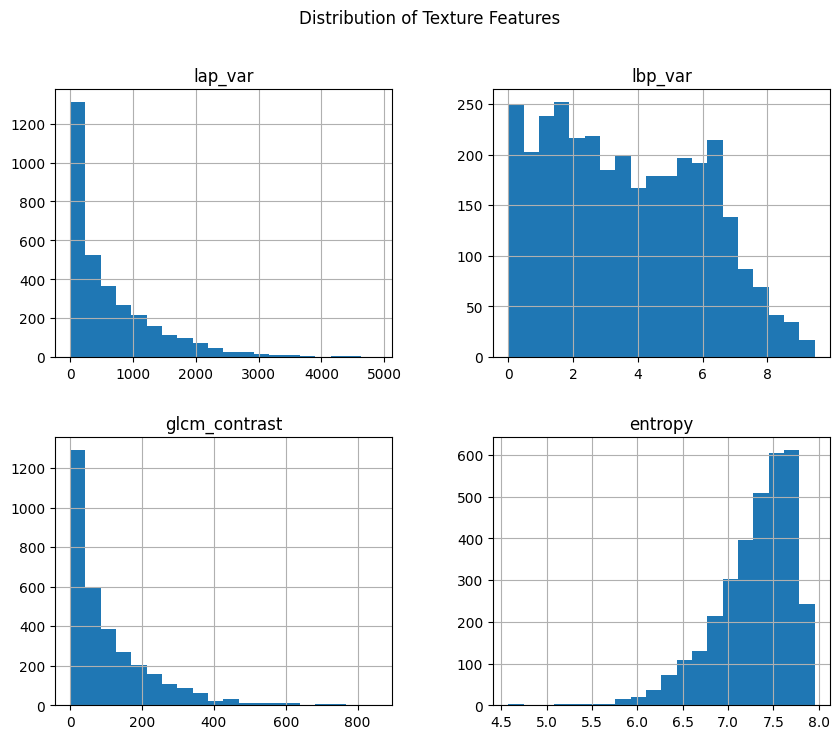

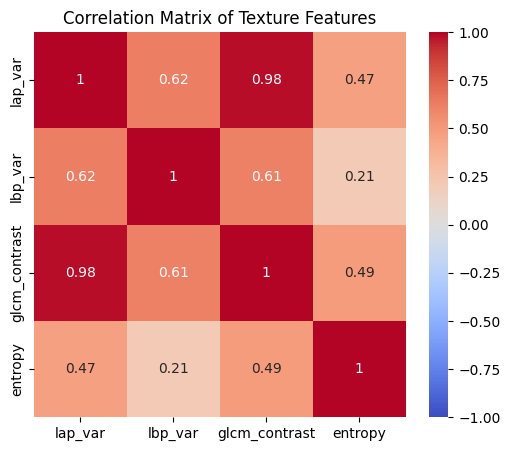

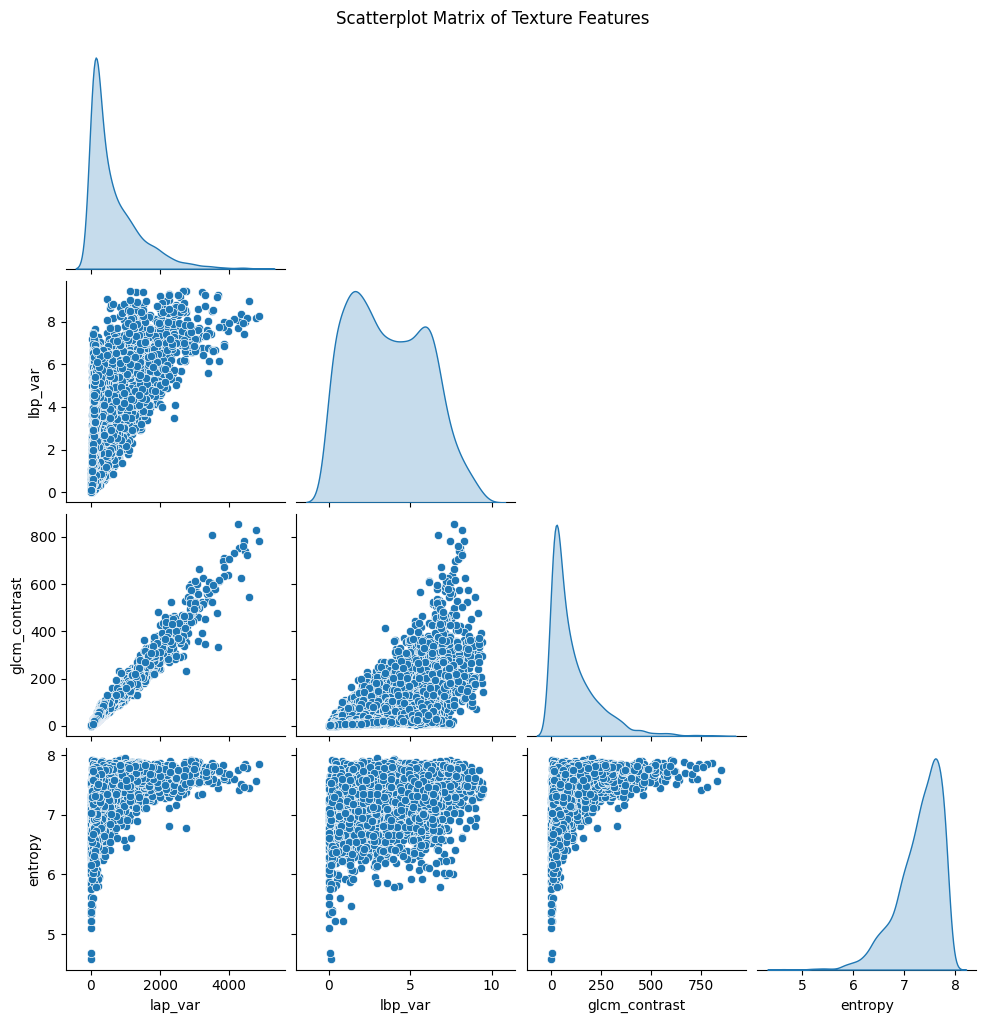

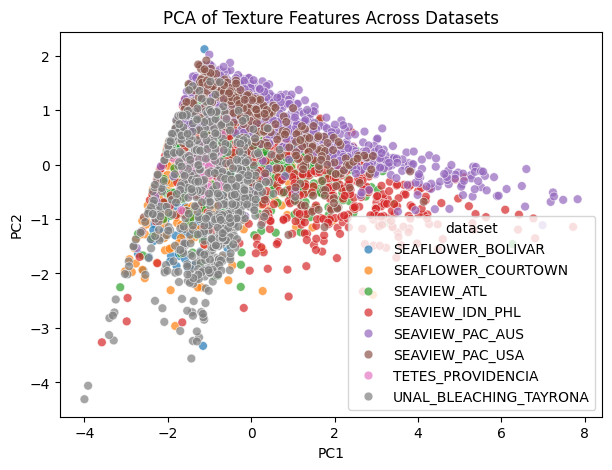

In [7]:
# ==============================================
# TEXTURE FEATURE EXTRACTION AND ANALYSIS
# ==============================================
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Your dataset from before
df_paths = df.copy()

records = []

print(f"🔍 Computing texture features for {len(df_paths)} images...")

for _, row in tqdm(df_paths.iterrows(), total=len(df_paths)):
    img_path = row["image_path"]
    mask_path = row["mask_path"]

    if not (img_path and mask_path):
        continue

    # Load image and mask
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if img is None or mask is None:
        continue

    # Apply mask to grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_masked = gray * (mask > 0)

    # Laplacian variance (sharpness)
    lap_var = cv2.Laplacian(gray_masked, cv2.CV_64F).var()

    # LBP variance
    lbp = local_binary_pattern(gray_masked, P=8, R=1, method='uniform')
    lbp_var = lbp.var()

    # GLCM contrast
    try:
        glcm = graycomatrix(gray_masked, [1], [0], symmetric=True, normed=True)
        glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
    except Exception:
        glcm_contrast = np.nan

    # Shannon entropy
    hist, _ = np.histogram(gray_masked[mask > 0], bins=256, range=(0, 255), density=True)
    entropy = -np.sum(hist * np.log2(hist + 1e-9))

    records.append({
        "dataset": row["dataset"],
        "split": row["split"],
        "image_path": img_path,
        "lap_var": lap_var,
        "lbp_var": lbp_var,
        "glcm_contrast": glcm_contrast,
        "entropy": entropy
    })

# Create new DataFrame
features_df = pd.DataFrame(records)
features_df.to_csv("../coral_project_outputs/texture_features.csv", index=False)

print(f"✅ Extracted features for {len(features_df)} samples.")
display(features_df.head())

# ==============================================
# VISUALIZATIONS
# ==============================================

# --- Histograms
features_df[["lap_var", "lbp_var", "glcm_contrast", "entropy"]].hist(figsize=(10,8), bins=20)
plt.suptitle("Distribution of Texture Features")
plt.show()

# --- Correlation Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(features_df[["lap_var", "lbp_var", "glcm_contrast", "entropy"]].corr(),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Texture Features")
plt.show()

# --- Scatterplot Matrix
sns.pairplot(features_df[["lap_var", "lbp_var", "glcm_contrast", "entropy"]],
             corner=True, diag_kind='kde')
plt.suptitle("Scatterplot Matrix of Texture Features", y=1.02)
plt.show()

# --- PCA Visualization
X_scaled = StandardScaler().fit_transform(features_df[["lap_var", "lbp_var", "glcm_contrast", "entropy"]].fillna(0))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['dataset'] = features_df['dataset']

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="dataset", s=40, alpha=0.7)
plt.title("PCA of Texture Features Across Datasets")
plt.show()
